# Shark Tank Analysis Hackathon Project

Welcome to our hackathon project! In this notebook we analyse the [Shark Tank US dataset](https://www.kaggle.com/datasets/thirumani/shark-tank-us-dataset) and transform the tabular data into a graph structure that represents startups and investors. The key aim is to leverage ArangoDB’s multi-model capabilities to persist the graph data and dynamically process natural language queries via an Agentic App.

## Step 1: Prepare Your Dataset

If your dataset is not already in a graph format, transform it into a node-edge structure. For example, you might define:
- **Nodes:** Sharks, Companies, and Deals.
- **Edges:** Relationships like "invests in," "negotiates with," or "competes against." 



In [1]:
# Example: Load the dataset (adjust the file path as needed)
import pandas as pd

data_path = '/kaggle/input/shark-tank-us-dataset/Shark Tank US dataset.csv'
df = pd.read_csv(data_path, encoding='unicode_escape')
pd.set_option('display.max_columns', None)
print(f"Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns")
df.head()

Loaded dataset with 1405 rows and 53 columns


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Season Number,Startup Name,Episode Number,Pitch Number,Season Start,Season End,Original Air Date,Industry,Business Description,Company Website,Pitchers Gender,Pitchers Average Age,Pitchers City,Pitchers State,Entrepreneur Names,Multiple Entrepreneurs,US Viewership,Original Ask Amount,Original Offered Equity,Valuation Requested,Got Deal,Total Deal Amount,Total Deal Equity,Deal Valuation,Number of Sharks in Deal,Investment Amount Per Shark,Equity Per Shark,Royalty Deal,Advisory Shares Equity,Loan,Deal Has Conditions,Barbara Corcoran Investment Amount,Barbara Corcoran Investment Equity,Mark Cuban Investment Amount,Mark Cuban Investment Equity,Lori Greiner Investment Amount,Lori Greiner Investment Equity,Robert Herjavec Investment Amount,Robert Herjavec Investment Equity,Daymond John Investment Amount,Daymond John Investment Equity,Kevin O Leary Investment Amount,Kevin O Leary Investment Equity,Guest Investment Amount,Guest Investment Equity,Guest Name,Barbara Corcoran Present,Mark Cuban Present,Lori Greiner Present,Robert Herjavec Present,Daymond John Present,Kevin O Leary Present,Guest Present
0,1,AvaTheElephant,1,1,9-Aug-09,5-Feb-10,9-Aug-09,Health/Wellness,Ava The Elephant - Baby and Child Care,http://www.avatheelephant.com/,Female,NaN,Atlanta,GA,Tiffany Krumins,0.0,4.15,50000,15.0,333333,1,50000.0,55.0,90909.0,1.0,50000.0,55.0,NaN,NaN,NaN,NaN,50000.0,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,1.0,1.0,NaN
1,1,MrTod'sPieFactory,1,2,9-Aug-09,5-Feb-10,9-Aug-09,Food and Beverage,Mr. Tod's Pie Factory - Specialty Food,http://whybake.com/,Male,NaN,Somerset,NJ,Tod Wilson,0.0,4.15,460000,10.0,4600000,1,460000.0,50.0,920000.0,2.0,230000.0,25.0,NaN,NaN,NaN,NaN,230000.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,230000.0,25.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,1.0,1.0,NaN
2,1,Wispots,1,3,9-Aug-09,5-Feb-10,9-Aug-09,Business Services,Wispots - Consumer Services,http://www.wispots.com/,Male,NaN,Cary,NC,Kevin Flannery,0.0,4.15,1200000,10.0,12000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,1.0,1.0,NaN
3,1,CollegeFoxesPackingBoxes,1,4,9-Aug-09,5-Feb-10,9-Aug-09,Lifestyle/Home,College Foxes Packing Boxes - Consumer Services,http://collegehunkshaulingjunk.com/,Male,NaN,Tampa,FL,"Nick Friedman, Omar Soliman",0.0,4.15,250000,25.0,1000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,1.0,1.0,NaN
4,1,IonicEar,1,5,9-Aug-09,5-Feb-10,9-Aug-09,Technology/Software,Ionic Ear - Novelties,NaN,Male,NaN,St. Paul,MN,Darrin Johnson,0.0,4.15,1000000,15.0,6666667,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,1.0,1.0,NaN


### Dataset Preparation(continued):
- We standardise column names and clean the dataset so that missing numeric values are replaced with 0 and missing string values with an empty string. 

In [2]:
# Standardize column names
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
print("Columns standardized:", df.columns.tolist())

Columns standardized: ['season_number', 'startup_name', 'episode_number', 'pitch_number', 'season_start', 'season_end', 'original_air_date', 'industry', 'business_description', 'company_website', 'pitchers_gender', 'pitchers_average_age', 'pitchers_city', 'pitchers_state', 'entrepreneur_names', 'multiple_entrepreneurs', 'us_viewership', 'original_ask_amount', 'original_offered_equity', 'valuation_requested', 'got_deal', 'total_deal_amount', 'total_deal_equity', 'deal_valuation', 'number_of_sharks_in_deal', 'investment_amount_per_shark', 'equity_per_shark', 'royalty_deal', 'advisory_shares_equity', 'loan', 'deal_has_conditions', 'barbara_corcoran_investment_amount', 'barbara_corcoran_investment_equity', 'mark_cuban_investment_amount', 'mark_cuban_investment_equity', 'lori_greiner_investment_amount', 'lori_greiner_investment_equity', 'robert_herjavec_investment_amount', 'robert_herjavec_investment_equity', 'daymond_john_investment_amount', 'daymond_john_investment_equity', 'kevin_o_leary

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1405 entries, 0 to 1404
Data columns (total 53 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   season_number                       1405 non-null   int64  
 1   startup_name                        1405 non-null   object 
 2   episode_number                      1405 non-null   int64  
 3   pitch_number                        1405 non-null   int64  
 4   season_start                        1405 non-null   object 
 5   season_end                          1361 non-null   object 
 6   original_air_date                   1405 non-null   object 
 7   industry                            1405 non-null   object 
 8   business_description                1405 non-null   object 
 9   company_website                     646 non-null    object 
 10  pitchers_gender                     1398 non-null   object 
 11  pitchers_average_age                469 non

In [4]:
# List the columns where you want to replace NaN with 0
investment_columns = [
    'barbara_corcoran_investment_amount', 
    'barbara_corcoran_investment_equity', 
    'mark_cuban_investment_amount', 
    'mark_cuban_investment_equity',
    'lori_greiner_investment_amount',
    'lori_greiner_investment_equity',
    'robert_herjavec_investment_amount',
    'robert_herjavec_investment_equity',
    'daymond_john_investment_amount',
    'daymond_john_investment_equity',
    'kevin_o_leary_investment_amount',
    'kevin_o_leary_investment_equity',
    'guest_investment_amount',
    'guest_investment_equity'
]

# Replace NaN with 0 for the specified columns
df[investment_columns] = df[investment_columns].fillna(0)

# Optionally, verify the result
print(df[investment_columns].isna().sum())


barbara_corcoran_investment_amount    0
barbara_corcoran_investment_equity    0
mark_cuban_investment_amount          0
mark_cuban_investment_equity          0
lori_greiner_investment_amount        0
lori_greiner_investment_equity        0
robert_herjavec_investment_amount     0
robert_herjavec_investment_equity     0
daymond_john_investment_amount        0
daymond_john_investment_equity        0
kevin_o_leary_investment_amount       0
kevin_o_leary_investment_equity       0
guest_investment_amount               0
guest_investment_equity               0
dtype: int64


In [5]:
list(df)

['season_number',
 'startup_name',
 'episode_number',
 'pitch_number',
 'season_start',
 'season_end',
 'original_air_date',
 'industry',
 'business_description',
 'company_website',
 'pitchers_gender',
 'pitchers_average_age',
 'pitchers_city',
 'pitchers_state',
 'entrepreneur_names',
 'multiple_entrepreneurs',
 'us_viewership',
 'original_ask_amount',
 'original_offered_equity',
 'valuation_requested',
 'got_deal',
 'total_deal_amount',
 'total_deal_equity',
 'deal_valuation',
 'number_of_sharks_in_deal',
 'investment_amount_per_shark',
 'equity_per_shark',
 'royalty_deal',
 'advisory_shares_equity',
 'loan',
 'deal_has_conditions',
 'barbara_corcoran_investment_amount',
 'barbara_corcoran_investment_equity',
 'mark_cuban_investment_amount',
 'mark_cuban_investment_equity',
 'lori_greiner_investment_amount',
 'lori_greiner_investment_equity',
 'robert_herjavec_investment_amount',
 'robert_herjavec_investment_equity',
 'daymond_john_investment_amount',
 'daymond_john_investment_equit

In [6]:
# List of columns to drop exactly as provided
columns_to_drop = [
  
    'pitch_number',
    'season_start',
    'season_end',
    'guest_name',
    'barbara_corcoran_present',
    'mark_cuban_present',
    'lori_greiner_present',
    'robert_herjavec_present',
    'daymond_john_present',
    'kevin_o_leary_present',
    'guest_present'
]

# Drop the specified columns from the DataFrame
df.drop(columns=columns_to_drop, inplace=True)

# Verify the remaining columns
print("Remaining columns:", df.columns.tolist())


Remaining columns: ['season_number', 'startup_name', 'episode_number', 'original_air_date', 'industry', 'business_description', 'company_website', 'pitchers_gender', 'pitchers_average_age', 'pitchers_city', 'pitchers_state', 'entrepreneur_names', 'multiple_entrepreneurs', 'us_viewership', 'original_ask_amount', 'original_offered_equity', 'valuation_requested', 'got_deal', 'total_deal_amount', 'total_deal_equity', 'deal_valuation', 'number_of_sharks_in_deal', 'investment_amount_per_shark', 'equity_per_shark', 'royalty_deal', 'advisory_shares_equity', 'loan', 'deal_has_conditions', 'barbara_corcoran_investment_amount', 'barbara_corcoran_investment_equity', 'mark_cuban_investment_amount', 'mark_cuban_investment_equity', 'lori_greiner_investment_amount', 'lori_greiner_investment_equity', 'robert_herjavec_investment_amount', 'robert_herjavec_investment_equity', 'daymond_john_investment_amount', 'daymond_john_investment_equity', 'kevin_o_leary_investment_amount', 'kevin_o_leary_investment_eq

In [7]:
import pandas as pd

# Load your DataFrame (assuming it's named df)
# df = pd.read_csv("your_data.csv")  # Uncomment if loading from a CSV

# Check data types
data_types = df.dtypes
print("Data Types:\n", data_types)

# Separate column names based on data types
string_columns = data_types[data_types == "object"].index.tolist()
numeric_columns = data_types[(data_types == "int64") | (data_types == "float64")].index.tolist()

# Replace NaN values accordingly
df[string_columns] = df[string_columns].fillna("")
df[numeric_columns] = df[numeric_columns].fillna(0)

# Confirm changes
print("Null values per column after cleaning:\n", df.isnull().sum())

# Save the cleaned dataset 
df.to_csv("cleaned_sharks.csv", index=False)


Data Types:
 season_number                           int64
startup_name                           object
episode_number                          int64
original_air_date                      object
industry                               object
business_description                   object
company_website                        object
pitchers_gender                        object
pitchers_average_age                   object
pitchers_city                          object
pitchers_state                         object
entrepreneur_names                     object
multiple_entrepreneurs                float64
us_viewership                         float64
original_ask_amount                     int64
original_offered_equity               float64
valuation_requested                     int64
got_deal                                int64
total_deal_amount                     float64
total_deal_equity                     float64
deal_valuation                        float64
number_of_sharks_in_d

## Step 2: Load Graph Data into NetworkX

Now that we have a tabular dataset, we need to convert it into a graph. Use Python scripts to define nodes and edges and load the resulting structure into NetworkX. This will help verify the structure before ingestion into ArangoDB.We start by mapping startups and investor-related fields to create a node–edge structure.

### We then construct a graph in NetworkX:
- Using Python’s NetworkX library, I built a bipartite-like graph where startups (with attributes like industry, business description, website, and demographic data) and investors (e.g., Barbara Corcoran, Mark Cuban, etc.) are nodes.
- The function add_investor_edge creates an edge between an investor and a startup only if the investment amount is greater than zero

For example:
- **Nodes:** Create unique nodes for each Shark and Company.
- **Edges:** Define edges based on the investment or negotiation events.

Visualize a small test graph to ensure correctness.

Graph has 1409 nodes and 1131 edges.


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128 (\x80) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 153 (\x99) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


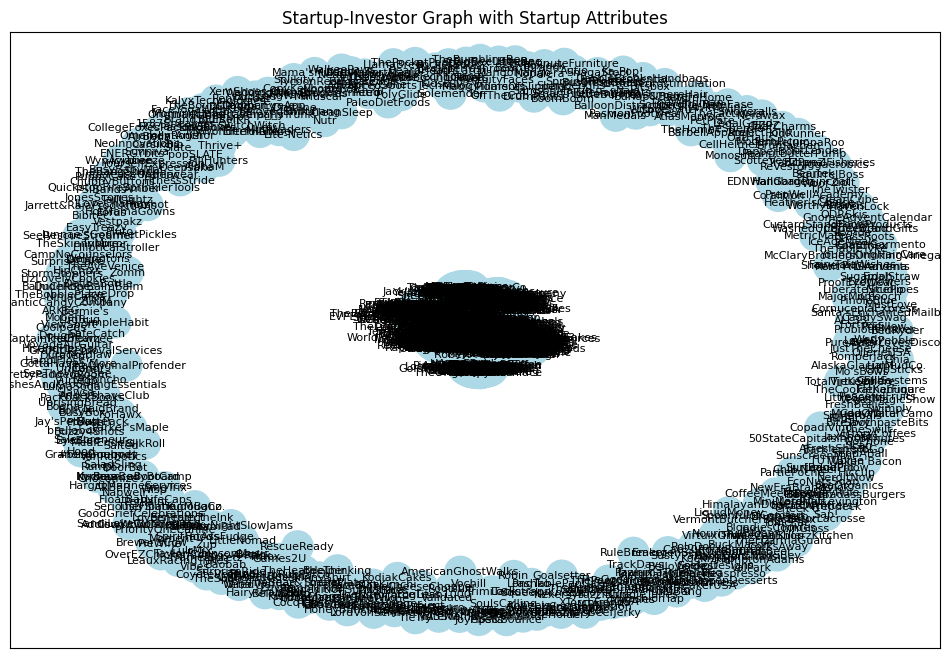

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# Create an empty graph
G = nx.Graph()

def add_investor_edge(startup, investor_name, investment_amount, investment_equity):
    # Only add an edge if the investment amount is greater than zero
    if investment_amount > 0:
        # Add investor node with type 'investor' if it doesn't already exist
        if investor_name not in G:
            G.add_node(investor_name, type='investor')
        # Add an edge with investment details
        G.add_edge(investor_name, startup, investment_amount=investment_amount, investment_equity=investment_equity)

# Iterate over each row in the DataFrame
for _, row in df.iterrows():
    # Retrieve the startup name
    startup = row['startup_name']
    
    # Create a dictionary of attributes for the startup
    startup_attrs = {
        'industry': row['industry'],
        'business_description': row['business_description'],
        'company_website': row['company_website'],
        'pitchers_gender': row['pitchers_gender'],
        'pitchers_average_age': row['pitchers_average_age'],
        'pitchers_city': row['pitchers_city'],
        'pitchers_state': row['pitchers_state']
    }
    
    # Add the startup node along with its attributes and specify its type
    G.add_node(startup, type='startup', **startup_attrs)
    
    # Add investor edges for each investor column
    add_investor_edge(startup, 'Barbara Corcoran', row['barbara_corcoran_investment_amount'], row['barbara_corcoran_investment_equity'])
    add_investor_edge(startup, 'Mark Cuban', row['mark_cuban_investment_amount'], row['mark_cuban_investment_equity'])
    add_investor_edge(startup, 'Lori Greiner', row['lori_greiner_investment_amount'], row['lori_greiner_investment_equity'])
    add_investor_edge(startup, 'Robert Herjavec', row['robert_herjavec_investment_amount'], row['robert_herjavec_investment_equity'])
    add_investor_edge(startup, 'Daymond John', row['daymond_john_investment_amount'], row['daymond_john_investment_equity'])
    add_investor_edge(startup, "Kevin O'Leary", row['kevin_o_leary_investment_amount'], row['kevin_o_leary_investment_equity'])
    add_investor_edge(startup, 'Guest', row['guest_investment_amount'], row['guest_investment_equity'])

# Print out some basic graph properties
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Visualize the graph using a spring layout
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
# Color nodes based on their type
node_colors = ['lightblue' if G.nodes[node].get('type') == 'startup' else 'lightgreen' for node in G.nodes()]
nx.draw_networkx(G, pos, node_color=node_colors, with_labels=True, node_size=500, font_size=8)
plt.title('Startup-Investor Graph with Startup Attributes')
plt.show()

1. The Circular Layout:

The nodes (representing entities in the network) are arranged in a circular layout. This is a common layout algorithm used in NetworkX for initial visualization, especially when the network structure isn't inherently hierarchical or spatial.
 
2. Node Clustering and Centrality:

The central black blob suggests a dense cluster of nodes with many connections. This could indicate a highly interconnected group of startups or investors.

## Step 3: Persist / Connect the Graph in ArangoDB

Once your graph is validated in NetworkX, We persist it to ArangoDB. We use the ArangoDB + NetworkX integration to:

- Create collections for nodes and edges (e.g., 'Sharks', 'Companies', 'investments').
- Persist the graph structure for scalable querying and management.

### Database & Collection Setup:
The notebook connects to an ArangoDB instance using the PyArango driver. Three collections are created:
- startups – A document collection to store startup nodes.
- investors – A document collection to store investor nodes.
- investments – An EdgeCollection used to persist edges representing investments.

Overwrite Mode:
Using save(overwrite=True), This was done to avoid duplicates as we were struggling to make the investments edge.
Edge Insertion:
The code explicitly assigns the edge document’s _from field to the investor (e.g., "investors/mark_cuban") and the _to field to the startup (e.g., "startups/classroomjams"). This guarantees that ArangoDB recognises these documents as graph edges.
.

In [1]:
!pip install pyArango

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.5/254.5 kB 9.4 MB/s eta 0:00:00
  Created wheel for pyArango: filename=pyArango-2.1.1-py2.py3-none-any.whl size=53233 sha256=c65031c1331c65ef329067730fff3038cddc0102186dfadd88cb9367fbbe711d
  Stored in directory: /root/.cache/pip/wheels/54/80/ff/9756fb6ac5984e690ebaa127126c32651dc3302e82c54353a0
Successfully built pyArango


In [17]:
from pyArango.connection import Connection
from pyArango.theExceptions import DocumentNotFoundError, CreationError
import re

# --------------------- Connection & Database Setup ---------------------
conn = Connection(
    arangoURL='your-url', 
    username='your_username', 
    password='your_password'
)
db_name = "your_dbname"

if db_name not in conn.databases:
    db = conn.createDatabase(name=db_name)
else:
    db = conn[db_name]

# Helper function to clean node keys (remove invalid characters)
def clean_key(value):
    return re.sub(r"[^a-zA-Z0-9_-]", "_", str(value)).lower()

# Function to ensure a collection exists
def ensure_collection(name, is_edge=False):
    if name not in db.collections:
        try:
            if is_edge:
                # Create as an edge collection using 'Edges' class
                db.createCollection(name=name, className="Edges")
            else:
                db.createCollection(name=name)
        except CreationError as e:
            print(f"⚠️ Error creating collection {name}: {e}")
    return db[name]

# Ensure collections exist
startup_collection = ensure_collection("startups")
investor_collection = ensure_collection("investors")

# Ensure investments is an edge collection (type=3)
if "investments" in db.collections:
    # Check if the existing collection is an edge collection
    if db["investments"].type != 3:
        print("🔄 Deleting existing 'investments' collection (not an edge collection)...")
        db["investments"].delete()  # Correct method to delete a collection
        investment_collection = ensure_collection("investments", is_edge=True)
    else:
        investment_collection = db["investments"]
else:
    investment_collection = ensure_collection("investments", is_edge=True)

# Verify collection types
print(f"Investments collection type: {investment_collection.type}")  # Should output 3

# --------------------- Persist Nodes ---------------------
def persist_nodes(collection, nodes, node_type):
    for node, data in nodes:
        node_key = clean_key(node)
        doc = {
            "_key": node_key,
            "name": node,  # Store the original name
            "type": node_type
        }
        
        # Add additional attributes based on node type
        if node_type == "startup":
            doc.update({
                "industry": data.get("industry", ""),
                "business_description": data.get("business_description", ""),
                "company_website": data.get("company_website", ""),
                "pitchers_gender": data.get("pitchers_gender", ""),
                "pitchers_average_age": data.get("pitchers_average_age", 0),
                "pitchers_city": data.get("pitchers_city", ""),
                "pitchers_state": data.get("pitchers_state", "")
            })
        elif node_type == "investor":
            doc.update({
                # Add investor-specific fields if needed
            })
        
        try:
            doc_obj = collection.createDocument(doc)
            doc_obj.save(overwrite=True)
            print(f"✓ Persisted {node_type}: {node_key}")
        except Exception as e:
            print(f"❌ Error persisting {node_type} {node_key}: {e}")

# Persist startups and investors
persist_nodes(startup_collection, ((n, d) for n, d in G.nodes(data=True) if d.get("type") == "startup"), "startup")
persist_nodes(investor_collection, ((n, d) for n, d in G.nodes(data=True) if d.get("type") == "investor"), "investor")

# --------------------- Persist Edges ---------------------
# Clear existing edges to avoid duplicates
if investment_collection.count() > 0:
    investment_collection.truncate()
    print("🗑️ Cleared existing edges.")

for src, dst, data in G.edges(data=True):
    # Determine roles: investor should be the source and startup the target
    if G.nodes[src]['type'] == 'investor' and G.nodes[dst]['type'] == 'startup':
        investor_node, startup_node = src, dst
    elif G.nodes[dst]['type'] == 'investor' and G.nodes[src]['type'] == 'startup':
        investor_node, startup_node = dst, src
    else:
        print(f"⚠️ Skipping edge {src} ↔ {dst}: Not an investor-startup relationship.")
        continue
    
    investor_key = clean_key(investor_node)
    startup_key = clean_key(startup_node)
    print(f"Processing edge: Investor={investor_key}, Startup={startup_key}")
    
    # Verify nodes exist before creating edge
    try:
        investor_doc = investor_collection[investor_key]
        startup_doc = startup_collection[startup_key]
        print(f"✅ Verified nodes: Investor={investor_key}, Startup={startup_key}")
    except DocumentNotFoundError:
        print(f"⚠️ Skipping edge {investor_key} -> {startup_key}: Missing node(s).")
        continue
    
    # Create edge document
    edge_key = f"{investor_key}_{startup_key}"
    edge_data = {
        "_key": edge_key,
        "_from": investor_doc._id,  # Use the actual document _id
        "_to": startup_doc._id,     # Use the actual document _id
        "investment_amount": data.get("investment_amount", 0),
        "investment_equity": data.get("investment_equity", 0)
    }
    
    try:
        # Use createDocument for edge creation
        edge_obj = investment_collection.createDocument(edge_data)
        edge_obj.save(overwrite=True)
        print(f"✓ Added edge: {investor_key} -> {startup_key}")
    except Exception as e:
        print(f"❌ Error adding edge {edge_key}: {e}")

# --------------------- Verify Persistence ---------------------
edge_query = """
FOR e IN investments
    RETURN {
        _key: e._key,
        _from: e._from,
        _to: e._to,
        investment_amount: e.investment_amount,
        investment_equity: e.investment_equity
    }
"""
edges = list(db.AQLQuery(edge_query, rawResults=True))
print(f"Total edges verified: {len(edges)}")
print("Sample edge:", edges[0] if edges else "No edges found")

# --------------------- Query: Startups Funded by Mark Cuban ---------------------
investor_id = "mark_cuban"  # Use the cleaned key format
query = f"""
FOR e IN investments
    FILTER e._from == "investors/{investor_id}"
    FOR s IN startups
        FILTER e._to == s._id
        RETURN {{
            startup_name: s.name || s._key,
            business: s.business_description,
            investment_amount: e.investment_amount,
            equity: e.investment_equity
        }}
"""
try:
    result = list(db.AQLQuery(query, rawResults=True))
    print(f"Startups funded by {investor_id}: {result}")
except Exception as e:
    print(f"❌ Error executing query: {e}")

# --------------------- Debugging ---------------------
# Check if Mark Cuban exists and has edges
try:
    investor_doc = investor_collection[investor_id]
    print(f"✅ Mark Cuban document: {investor_doc}")
except DocumentNotFoundError:
    print(f"❌ Mark Cuban document not found: {investor_id}")

edge_query_debug = f"""
FOR e IN investments
    FILTER e._from == "investors/{investor_id}"
    RETURN e
"""
try:
    mark_edges = list(db.AQLQuery(edge_query_debug, rawResults=True))
    print(f"Edges from Mark Cuban: {mark_edges}")
except Exception as e:
    print(f"❌ Error fetching edges: {e}")

Investments collection type: 3
✓ Persisted startup: avatheelephant
✓ Persisted startup: mrtod_spiefactory
✓ Persisted startup: wispots
✓ Persisted startup: collegefoxespackingboxes
✓ Persisted startup: ionicear
✓ Persisted startup: aperfectpear
✓ Persisted startup: classroomjams
✓ Persisted startup: lifebelt
✓ Persisted startup: crookedjaw
✓ Persisted startup: stickynoteholder
✓ Persisted startup: turbobaster
✓ Persisted startup: stressfreekids
✓ Persisted startup: kwyztachopstickart
✓ Persisted startup: 50statecapitalsin50minutes
✓ Persisted startup: voyageairguitar
✓ Persisted startup: giftcardrescue
✓ Persisted startup: coverplay
✓ Persisted startup: graffitiremovalservices
✓ Persisted startup: soulscalling
✓ Persisted startup: coffeebrandgifts
✓ Persisted startup: mytherapyjournal
✓ Persisted startup: bodyjac
✓ Persisted startup: goodgriefcelebrations
✓ Persisted startup: granolagourmet
✓ Persisted startup: faceblok
✓ Persisted startup: porkbarrelbbqsauce
✓ Persisted startup: eleme

In [18]:
print(f"Investments collection type: {investment_collection.type}")

Investments collection type: 3


In [19]:
query = "FOR s IN startups RETURN s"
result = db.AQLQuery(query, rawResults=True)
print("Startups:", result[:10])


Startups: [{'_key': 'AvaTheElephant', '_id': 'startups/AvaTheElephant', '_rev': '_jUfipAO---', 'type': 'startup', 'industry': 'Health/Wellness', 'business_description': 'Ava The Elephant - Baby and Child Care', 'company_website': 'http://www.avatheelephant.com/', 'pitchers_gender': 'Female', 'pitchers_average_age': '', 'pitchers_city': 'Atlanta', 'pitchers_state': 'GA'}, {'_key': "mrtod'spiefactory", '_id': "startups/mrtod'spiefactory", '_rev': '_jUfmaRy---', 'type': 'startup', 'industry': 'Food and Beverage', 'business_description': "Mr. Tod's Pie Factory - Specialty Food", 'company_website': 'http://whybake.com/', 'pitchers_gender': 'Male', 'pitchers_average_age': '', 'pitchers_city': 'Somerset', 'pitchers_state': 'NJ'}, {'_key': "rompn'roll", '_id': "startups/rompn'roll", '_rev': '_jUfmeA2---', 'type': 'startup', 'industry': 'Children/Education', 'business_description': "Romp n' Roll - Baby and Children's Entertainment", 'company_website': 'http://www.rompnroll.com/', 'pitchers_gend

In [63]:
# Debug: Check Mark Cuban's node type in the graph
mark_cuban_type = G.nodes["Mark Cuban"].get("type")
print(f"Mark Cuban node type: {mark_cuban_type}")

Mark Cuban node type: investor


In [52]:
query = "FOR i IN investors RETURN i"
result = db.AQLQuery(query, rawResults=True)
print("Investors:", result[:10])


Investors: [{'_key': "kevin_o'leary", '_id': "investors/kevin_o'leary", '_rev': '_jUfmawC---', 'type': 'investor', 'industry': '', 'business_description': '', 'company_website': '', 'pitchers_gender': '', 'pitchers_average_age': 0, 'pitchers_city': '', 'pitchers_state': ''}, {'_key': 'barbara_corcoran', '_id': 'investors/barbara_corcoran', '_rev': '_jUsjln2---', 'name': 'Barbara Corcoran', 'type': 'investor'}, {'_key': 'daymond_john', '_id': 'investors/daymond_john', '_rev': '_jUsjlx6---', 'name': 'Daymond John', 'type': 'investor'}, {'_key': 'robert_herjavec', '_id': 'investors/robert_herjavec', '_rev': '_jUsjl8G---', 'name': 'Robert Herjavec', 'type': 'investor'}, {'_key': 'kevin_o_leary', '_id': 'investors/kevin_o_leary', '_rev': '_jUsjmGO---', 'name': "Kevin O'Leary", 'type': 'investor'}, {'_key': 'mark_cuban', '_id': 'investors/mark_cuban', '_rev': '_jUsjmQS---', 'name': 'Mark Cuban', 'type': 'investor'}, {'_key': 'guest', '_id': 'investors/guest', '_rev': '_jUsjmaa---', 'name': '

In [53]:
query = "FOR e IN investments RETURN e"
result = db.AQLQuery(query, rawResults=True)
print("Investments:", result[:10])


Investments: [{'_key': 'barbara_corcoran_avatheelephant', '_id': 'investments/barbara_corcoran_avatheelephant', '_rev': '_jUsjnY----', 'investment_amount': 50000, 'investment_equity': 55}, {'_key': 'barbara_corcoran_mrtod_spiefactory', '_id': 'investments/barbara_corcoran_mrtod_spiefactory', '_rev': '_jUsjn3W---', 'investment_amount': 230000, 'investment_equity': 25}, {'_key': 'barbara_corcoran_classroomjams', '_id': 'investments/barbara_corcoran_classroomjams', '_rev': '_jUsjoY6---', 'investment_amount': 50000, 'investment_equity': 20}, {'_key': 'barbara_corcoran_stressfreekids', '_id': 'investments/barbara_corcoran_stressfreekids', '_rev': '_jUsjo4O---', 'investment_amount': 250000, 'investment_equity': 50}, {'_key': 'barbara_corcoran_coverplay', '_id': 'investments/barbara_corcoran_coverplay', '_rev': '_jUsjpY6---', 'investment_amount': 35000, 'investment_equity': 40}, {'_key': 'barbara_corcoran_bodyjac', '_id': 'investments/barbara_corcoran_bodyjac', '_rev': '_jUsjqGm---', 'investm

## Step 4: Build the Agentic App for Querying the Graph

This is the creative heart of the project. The Agentic App will process natural language queries and dynamically choose the optimal retrieval method:

### Dual Query Execution

The notebook includes sample AQL queries to demonstrate how natural language queries (e.g., “Show me startups funded by Mark Cuban”) are translated into AQL that traverse the graph.
In our submission, the Agentic App integrates LangChain to process more complex queries. Here we trial the query logic, showing how the app retrieves insights from the graph in real time.

### Hybrid Query Execution

For queries that require both traversal and deeper analysis, the Agentic App can combine AQL results with GPU analytics to produce a rich, contextual response.

Below is a sample code snippet that outlines the logic for processing natural language queries and selecting the appropriate execution path.

In [2]:
import networkx as nx
from pyArango.connection import Connection
import re
import traceback

# --- ArangoDB Connection Setup ---
conn = Connection(
    arangoURL='your-url', 
    username='your_username', 
    password='your_password'
)
db_name = "your_dbname"
db = conn[db_name]

# --- Query Type Detection Functions ---
def is_simple_query(query: str) -> bool:
    """
    Identify queries that ask for direct connections.
    Example: "Find all direct deals of Kevin O'Leary"
    """
    query_lower = query.lower()
    return "direct deal" in query_lower or "direct connection" in query_lower

def is_complex_query(query: str) -> bool:
    """
    Identify queries that ask for advanced analytics.
    Example: "Find the most influential shark in the network"
    """
    query_lower = query.lower()
    return "influential" in query_lower or "pagerank" in query_lower or "community" in query_lower

def is_hybrid_query(query: str) -> bool:
    """
    Identify queries that require both direct traversal and advanced analytics.
    Example: "Show me both direct deals and community insights for Mark Cuban"
    """
    query_lower = query.lower()
    return "both" in query_lower or "combined" in query_lower

# --- Investor Name Extraction ---
def extract_investor_name(query: str) -> str:
    """
    Improved investor name extraction using regex to handle different query patterns
    """
    # Look for patterns like "of [Investor]" or "for [Investor]"
    patterns = [
        r"of (\w+ \w+?)($| )",  # Matches "of Kevin O'Leary"
        r"for (\w+ \w+?)($| )"   # Matches "for Mark Cuban"
    ]
    
    for pattern in patterns:
        match = re.search(pattern, query, re.IGNORECASE)
        if match:
            name = match.group(1).replace("'", "").replace(" ", "_").lower()
            print(f"Extracted investor name: {name}")
            return name
    
    # Fallback: try to find any investor name from known investors
    known_investors = ['mark_cuban', 'kevin_oleary', 'lori_greiner', 'barbara_corcoran']
    for investor in known_investors:
        if investor in query.lower().replace("'", "").replace(" ", "_"):
            print(f"Matched known investor: {investor}")
            return investor
    
    raise ValueError(f"Could not extract investor name from query: {query}")

# --- Execution Functions ---
def execute_aql_traversal(query: str) -> dict:
    """
    Converts a natural language query into an AQL traversal on the Shark Tank graph.
    Example: "Find all direct deals of Kevin O'Leary"
    """
    try:
        print("Executing AQL traversal for simple query on Shark Tank data...")
        
        investor_name = extract_investor_name(query)
        investor_key = f"investors/{investor_name}"
        print(f"Final investor key: {investor_key}")

        # Verify investor exists first
        investor_check = f'DOCUMENT("{investor_key}")'
        if not db.AQLQuery(f'RETURN {investor_check}', rawResults=True)[0]:
            return {"error": f"Investor {investor_name} not found"}

        # Execute main query
        aql_query = f"""
        FOR e IN investments
            FILTER e._from == "{investor_key}"
            FOR s IN startups
                FILTER e._to == s._id
                RETURN s
        """
        print(f"Executing AQL:\n{aql_query}")
        
        result = list(db.AQLQuery(aql_query, rawResults=True))
        return {"result": result}
        
    except Exception as e:
        return {"error": str(e), "details": traceback.format_exc()}

def execute_complex_analysis(query: str) -> dict:
    """
    Executes complex analytics on the Shark Tank network.
    Example: "Find the most influential shark in the network"
    """
    print("Executing complex analytics for Shark Tank data...")
    
    # Load the graph from ArangoDB into NetworkX
    G = nx.DiGraph()
    
    # Fetch all edges from the investments collection
    edge_query = """
    FOR e IN investments
        RETURN {
            _from: e._from,
            _to: e._to,
            investment_amount: e.investment_amount
        }
    """
    edges = list(db.AQLQuery(edge_query, rawResults=True))
    
    # Add edges to the NetworkX graph
    for edge in edges:
        investor = edge["_from"].split("/")[1]  # Extract investor key
        startup = edge["_to"].split("/")[1]     # Extract startup key
        G.add_edge(investor, startup, weight=edge["investment_amount"])
    
    # Compute PageRank as a measure of influence
    pagerank = nx.pagerank(G)
    return {"pagerank": pagerank}

def execute_hybrid_query(query: str) -> dict:
    """
    Combines both AQL traversal and advanced analytics to provide a comprehensive answer.
    Example: "Show me both direct deals and community insights for Mark Cuban"
    """
    print("Executing hybrid query: combining AQL traversal and complex analytics on Shark Tank data...")
    aql_result = execute_aql_traversal(query)
    analytics_result = execute_complex_analysis(query)
    
    # Merge the results for a richer contextual response.
    return {
        "aql_result": aql_result,
        "analytics_result": analytics_result
    }

# --- Main Query Processing Function ---
def process_query(query: str) -> dict:
    """
    Processes a natural language query against the Shark Tank data.
    Selects the optimal retrieval method based on query complexity.
    """
    query_lower = query.lower()
    
    if any(word in query_lower for word in ["direct deal", "direct connection"]):
        print("Detected simple query.")
        return execute_aql_traversal(query)
        
    elif any(word in query_lower for word in ["influential", "pagerank", "community"]):
        print("Detected complex query.")
        return execute_complex_analysis(query)
        
    elif "both" in query_lower or "combined" in query_lower:
        print("Detected hybrid query.")
        return execute_hybrid_query(query)
        
    else:
        print("Query type not recognized, attempting best-effort AQL traversal")
        return execute_aql_traversal(query)

# --- Example Usage ---
if __name__ == "__main__":
    queries = [
        "Find all direct deals of Kevin O'Leary",
        "Show me both direct deals and community insights for Mark Cuban",
        "What are the top 5 startups by valuation?",
        "Who is the most influential shark?",
        "Which investors collaborate the most on investments?",
        "Which startup received the most amout of capital?",
        "Top 5 startups by funding received",
        "Which startups received support from at least 4 sharks?",
        "What is the biggest single sum of capital that Lori Greiner provided and what is the name of the startup?"
        "Which industry has the most startups?",
    ]
    
    for q in queries:
        print(f"\n \n Processing query: {q}")
        result = process_query(q)
        print("\n \n Query result:", result)


 
 Processing query: Find all direct deals of Kevin O'Leary
Detected simple query.
Executing AQL traversal for simple query on Shark Tank data...
Matched known investor: kevin_oleary
Final investor key: investors/kevin_oleary

 
 Query result: {'error': 'Investor kevin_oleary not found'}

 
 Processing query: Show me both direct deals and community insights for Mark Cuban
Detected simple query.
Executing AQL traversal for simple query on Shark Tank data...
Extracted investor name: mark_cuban
Final investor key: investors/mark_cuban
Executing AQL:

        FOR e IN investments
            FILTER e._from == "investors/mark_cuban"
            FOR s IN startups
                FILTER e._to == s._id
                RETURN s
        

 
 Query result: {'result': [{'_key': 'classroomjams', '_id': 'startups/classroomjams', '_rev': '_jVA7cUi---', 'name': 'ClassroomJams', 'type': 'startup', 'industry': 'Children/Education', 'business_description': 'Classroom Jams - Education', 'company_website'

### Next Steps for the Agentic App

We built a streamlit app with two main functionalities:

**1. Chat Interface (Tab 1):**

* **Natural Language Q&A:**
    * Users can ask questions about Shark Tank data using natural language.
    * It uses LangChain with Google's Gemini LLM to process queries against an ArangoDB graph database.
    * The `ArangoGraphQAChain` allows for querying the graph database with natural language.
* **Error Handling:**
    * Includes error handling to catch and display issues during query processing.

**2. Analytics Dashboard (Tab 2):**

* **Data Visualizations:**
    * Provides interactive visualizations of Shark Tank investment data.
    * **Investment Distribution:** Displays a histogram of investment amounts.
    * **Shark Activity:** Shows a bar chart of shark investment activity, including deal count and total invested amount.
    * **Investor-Startup Network:** Visualizes the network of investors and startups using a Plotly graph.
    * It uses AQL queries to fetch data from the ArangoDB database and display Graph Objects plotly express interactive charts.
    * NetworkX is used to construct the network graph.

In [ ]:
import streamlit as st
import networkx as nx
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from pyArango.connection import Connection
from arango import ArangoClient
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.graphs import ArangoGraph
from langchain.chains import ArangoGraphQAChain
from langchain_core.prompts import ChatPromptTemplate
import os

# Initialize Google Gemini
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-thinking-exp",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

# ArangoDB Connection
arangoURL=os.environ["ARANGO_URL"]
username=os.environ["ARANGO_USER"]
password=os.environ["ARANGO_PASSWORD"]
dbName=os.environ["DB_NAME"]
    

# Streamlit App Configuration
st.set_page_config(page_title="Shark Tank Analytics", layout="wide")

# Initialize Session State
if "chat_history" not in st.session_state:
    st.session_state.chat_history = []

# Page Layout
st.title("🦈 Shark Tank Analytics Platform")
tab1, tab2 = st.tabs(["Chat Interface", "Analytics Dashboard"])

# Chat Tab
with tab1:
    st.header("Chat with Shark Tank Data")
    
    # Chat Input
    user_query = st.chat_input("Ask about investments, sharks, or startups...")
    
    # Initialize ArangoGraph
    db = ArangoClient(hosts=arangoURL).db(dbName,
     username, password, verify=True)
   
    graph = ArangoGraph(db)
    
    # LangChain Q&A Chain
    chain = ArangoGraphQAChain.from_llm(llm, graph=graph,allow_dangerous_requests=True)
    
    # Display Chat History
    for message in st.session_state.chat_history:
        with st.chat_message(message["role"]):
            st.markdown(message["content"])
    
    # Process Query
    if user_query:
        # Add user message to history
        st.session_state.chat_history.append({"role": "user", "content": user_query})
        
        with st.chat_message("user"):
            st.markdown(user_query)
        
        # Process with LangChain
        try:
            response = chain.run(user_query)
            
            with st.chat_message("assistant"):
                # Enhanced response formatting
                if isinstance(response, dict):
                    if "result" in response:
                        if isinstance(response["result"], list):
                            df = pd.DataFrame(response["result"])
                            st.dataframe(df)
                            st.session_state.chat_history.append({
                                "role": "assistant",
                                "content": f"Found {len(df)} results"
                            })
                        else:
                            st.write(response["result"])
                            st.session_state.chat_history.append({
                                "role": "assistant",
                                "content": response["result"]
                            })
                    else:
                        st.write(response)
                        st.session_state.chat_history.append({
                            "role": "assistant",
                            "content": str(response)
                        })
                else:
                    st.write(response)
                    st.session_state.chat_history.append({
                        "role": "assistant",
                        "content": response
                    })
        
        except Exception as e:
            st.error(f"Error processing query: {str(e)}")
            st.session_state.chat_history.append({
                "role": "assistant",
                "content": f"Error: {str(e)}"
            })

# Dashboard Tab
with tab2:
    st.header("Investment Analytics Dashboard")
    
    # Fetch data for visualizations
    conn = Connection(
       arangoURL=arangoURL,
       username=username, 
       password=password
    )
    db_name = dbName
    db = conn[db_name]
    
    # Investment Amount Distribution
    st.subheader("Investment Distribution")
    investment_query = """
    FOR investment IN investments
        RETURN investment.investment_amount
    """
    investments = db.AQLQuery(investment_query, rawResults=True)
    if investments:
        st.write("Sample investment data:", investments[:5])
        # Flatten the result in case each element is a list.
        flat_investments = []
        for item in investments:
            if isinstance(item, list):
                flat_investments.extend(item)
            else:
                flat_investments.append(item)
                
        df_investments = pd.DataFrame({'investment_amount': flat_investments})
        fig = px.histogram(
            df_investments,
            x="investment_amount",
            nbins=20,
            labels={"investment_amount": "Investment Amount"},
            title="Distribution of Investment Amounts"
        )
        st.plotly_chart(fig, use_container_width=True)
    
    # Shark Activity
    st.subheader("Shark Investment Activity")
    shark_query = """
    WITH startups
    FOR shark IN investors
        LET deals = (
            FOR v IN 1..1 OUTBOUND shark investments
                RETURN v
        )
        RETURN {
            shark: shark.name,
            deal_count: LENGTH(deals),
            total_invested: SUM(deals[*].investment_amount)
        }
    """
    shark_data = db.AQLQuery(shark_query, rawResults=True)
    if shark_data:
        df = pd.DataFrame(shark_data)
        fig = px.bar(
            df,
            x="shark",
            y=["deal_count", "total_invested"],
            title="Shark Investment Activity",
            barmode="group"
        )
        st.plotly_chart(fig, use_container_width=True)
    
    # Network Visualization
    st.subheader("Investor-Startup Network")
    graph_query = """
    FOR edge IN investments
        LIMIT 50
        RETURN {
            source: SPLIT(edge._from, '/')[1],
            target: SPLIT(edge._to, '/')[1],
            amount: edge.investment_amount
        }
    """
    edges = db.AQLQuery(graph_query, rawResults=True)
    if edges:
        G = nx.from_pandas_edgelist(
            pd.DataFrame(edges),
            source="source",
            target="target",
            edge_attr="amount"
        )
        
        # Plotly network visualization
        pos = nx.spring_layout(G)
        edge_x = []
        edge_y = []
        for edge in G.edges():
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            edge_x.extend([x0, x1, None])
            edge_y.extend([y0, y1, None])
        
        edge_trace = go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=0.5, color='#888'),
            hoverinfo='none',
            mode='lines'
        )
        
        node_x = []
        node_y = []
        text = []
        for node in G.nodes():
            x, y = pos[node]
            node_x.append(x)
            node_y.append(y)
            text.append(node)
        
        node_trace = go.Scatter(
            x=node_x, y=node_y,
            mode='markers+text',
            text=text,
            textposition="bottom center",
            marker=dict(
                showscale=True,
                colorscale='YlGnBu',
                size=10,
                color=[],
                line_width=2
            )
        )
        
        fig = go.Figure(data=[edge_trace, node_trace],
                     layout=go.Layout(
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                     )
                    )
        st.plotly_chart(fig, use_container_width=True)

# Instructions for Setup
"""
To run this app:

1. Install dependencies:
pip install streamlit arango langchain langchain-community langchain-google-genai pyArango plotly networkx

2. Create a .streamlit/secrets.toml file with:
[ARANGO_URL]
ARANGO_USER = "root"
ARANGO_PASSWORD = "your_password"

3. Run with:
streamlit run shark_tank_app.py
"""

## Conclusion

This notebook has guided us through transforming the dataset into a graph, verifying its structure with NetworkX, persisting it to ArangoDB, and finally creating an innovative Agentic App for querying the graph. 